## Pandas Profiling: USA Air Pollution Data
Source of data: https://data.world/data-society/us-air-pollution-data

The autoreload instruction reloads modules automatically before code execution, which is helpful for the update below.

In [ ]:
%load_ext autoreload # Load the autoreload extension
%autoreload 2 # Autoreload all modules

Make sure that we have the latest version of pandas-profiling.

In [1]:
%%capture # Hide output
import sys

%{sys.executable} -m pip install -U pandas-profiling[notebook] # Install the pandas-profiling package
%pip install jupyter-contrib-nbextensions # Install the jupyter_contrib_nbextensions package
%jupyter nbextension enable --py widgetsnbextension # Enable the ipywidgets extension

UsageError: unrecognized arguments: Hide output


You might want to restart the kernel now.

### Import libraries

In [1]:
import pandas as pd

from ydata_profiling import ProfileReport
from ydata_profiling.utils.cache import cache_file

### Load and prepare the dataset

In [2]:
file_name = cache_file(
    "pollution_us_2000_2016.csv",
    "https://query.data.world/s/mz5ot3l4zrgvldncfgxu34nda45kvb",
)

df = pd.read_csv(file_name, index_col=[0])

In [3]:
df.head()

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,22.958333,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11794 entries, 83158 to 102037
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   State Code         11794 non-null  int64         
 1   County Code        11794 non-null  int64         
 2   Site Num           11794 non-null  int64         
 3   Address            11794 non-null  object        
 4   State              11794 non-null  object        
 5   County             11794 non-null  object        
 6   City               11794 non-null  object        
 7   Date Local         11794 non-null  datetime64[ns]
 8   NO2 Units          11794 non-null  object        
 9   NO2 Mean           11794 non-null  float64       
 10  NO2 1st Max Value  11794 non-null  float64       
 11  NO2 1st Max Hour   11794 non-null  int64         
 12  NO2 AQI            11794 non-null  int64         
 13  O3 Units           11794 non-null  object        
 14  O3 Mea

In [5]:
# filter the df to only include state == 'Oregon' and count the number of rows
oregon_df = df[df['State'] == 'Oregon']
oregon_df.shape[0]

11794

In [7]:

# We will only consider the data from Arizone state for this example
df = df[df["State"] == "Oregon"]
df["Date Local"] = pd.to_datetime(df["Date Local"])

In [11]:
df.shape

(11794, 28)

### Multi-entity time-series

In [12]:
# print the unique value for each column
for col in df.columns:
    print(f"Unique values for {col} are: {df[col].unique()}")

Unique values for State Code are: [41]
Unique values for County Code are: [51]
Unique values for Site Num are: [80]
Unique values for Address are: ['SE LAFAYETTE/5824 SE LAFAYETTE']
Unique values for State are: ['Oregon']
Unique values for County are: ['Multnomah']
Unique values for City are: ['Portland']
Unique values for Date Local are: <DatetimeArray>
['2007-05-02 00:00:00', '2007-05-03 00:00:00', '2007-05-04 00:00:00',
 '2007-05-05 00:00:00', '2007-05-06 00:00:00', '2007-05-07 00:00:00',
 '2007-05-08 00:00:00', '2007-05-09 00:00:00', '2007-05-10 00:00:00',
 '2007-05-11 00:00:00',
 ...
 '2015-12-22 00:00:00', '2015-12-23 00:00:00', '2015-12-24 00:00:00',
 '2015-12-25 00:00:00', '2015-12-26 00:00:00', '2015-12-27 00:00:00',
 '2015-12-28 00:00:00', '2015-12-29 00:00:00', '2015-12-30 00:00:00',
 '2015-12-31 00:00:00']
Length: 2949, dtype: datetime64[ns]
Unique values for NO2 Units are: ['Parts per billion']
Unique values for NO2 Mean are: [16.       12.083333 11.782609 ... 19.320833 14

The support to time series can be enabled by passing the parameter tsmode=True to the ProfileReport when its enabled, pandas profiling will try to identify time-dependent features using the feature's autocorrelation, which requires a sorted DataFrame or the definition of the `sortby` parameter.

When a feature is identified as time series will trigger the following changes:
   - the histogram will be replaced by a line plot
   - the feature details will have a new tab with autocorrelation and partial autocorrelation plots
   - two new warnings: `NON STATIONARY` and `SEASONAL` (which indicates that the series may have seasonality)

In cases where the data has multiple entities,  as in this example, where we have different meteorological stations, each station can be interpreted as a time series, its necessary to filter the entities and profile each station separately.

The following plot showcases the amount of data for each entity over time. In this case the data from the stations started being collected at the same period, and the data is collected hourly so they have the same amount of data per period.

c:\Users\Steve\AppData\Local\Programs\Python\Python312\Lib\site-packages\ydata_profiling\visualisation\plot.py:835: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby([entity_column, "__bins"])[sortbykey].count()
c:\Users\Steve\AppData\Local\Programs\Python\Python312\Lib\site-packages\ydata_profiling\visualisation\plot.py:836: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df = df.reset_index().pivot_table(entity_column, "__bins", sortbykey).T


<Axes: xlabel='Time'>

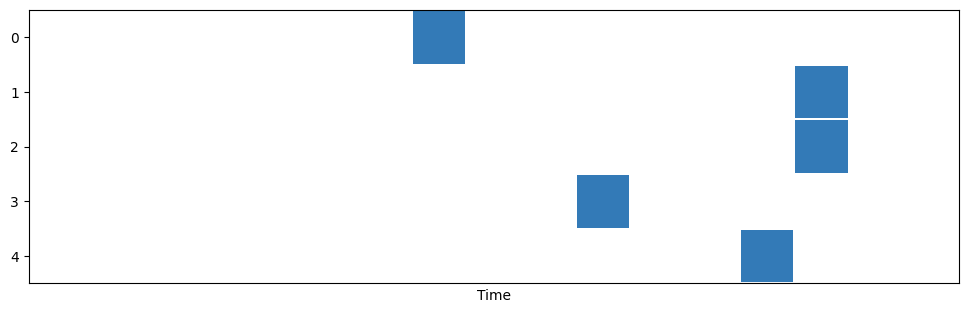

In [8]:
from ydata_profiling.visualisation.plot import timeseries_heatmap

timeseries_heatmap(dataframe=df, entity_column="Site Num", sortby="Date Local")

In [9]:
# Return the profile per station
for group in df.groupby("Site Num"):
    # Running 1 profile per station
    profile = ProfileReport(
        group[1],
        tsmode=True,
        sortby="Date Local",
        # title=f"Air Quality profiling - Site Num: {group[0]}"
    )

    profile.to_file(f"Ts_Profile_{group[0]}.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile = ProfileReport(
    group[1],
    tsmode=True,
    sortby="Date Local",
    # title=f"Air Quality profiling - Site Num: {group[0]}"
)

profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]